In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import statsmodels.stats.multitest
import operator




def wrap_ttest(df, label_column, comparison_columns=None, alpha=.05, return_all=False, correction_method='bonferroni', mincount=3, pval_return_corrected=True):
    try:
        '''Verify precondition that label column exists and has exactly 2 unique values'''
        label_values = df[label_column].unique()
        if len(label_values) != 2:
            print("Incorrectly Formatted Dataframe! Label column must have exactly 2 unique values.")
            return None
        
        '''Partition dataframe into two sets, one for each of the two unique values from the label column'''
        partition1 = df.loc[df[label_column] == label_values[0]]
        partition2 = df.loc[df[label_column] == label_values[1]]

        '''If no comparison columns specified, use all columns except the specified labed column'''
        if not comparison_columns:
            comparison_columns = list(df.columns)
            comparison_columns.remove(label_column)

        '''Determine the number of real valued columns on which we will do t-tests'''
        number_of_comparisons = len(comparison_columns)


        '''Store comparisons and p-values in two arrays'''
        comparisons = []
        pvals = []
        
        '''Loop through each comparison column, perform the t-test, and record the p-val'''
#         import pdb; pdb.set_trace()
        for column in comparison_columns:
            if len(partition1[column].dropna(axis=0)) <= mincount:
                continue
            elif len(partition2[column].dropna(axis=0)) <= mincount:
                continue
            else:
                stat, pval = scipy.stats.ttest_ind(partition1[column].dropna(axis=0), partition2[column].dropna(axis=0))
                comparisons.append(column)
                pvals.append(pval)
                
        '''Correct for multiple testing to determine if each comparison meets the new cutoff'''
        results = statsmodels.stats.multitest.multipletests(pvals=pvals, alpha=alpha, method=correction_method)
        reject = results[0]

        '''Format results in a pandas dataframe'''
        results_df = pd.DataFrame(columns=['Comparison','P_Value'])

        '''If return all, add all comparisons and p-values to dataframe'''
        if return_all:
            if pval_return_corrected:
                results_df['Comparison'] = comparisons
                results_df['P_Value'] = results[1]

            else:
                results_df['Comparison'] = comparisons
                results_df['P_Value'] = pvals

            '''Else only add significant comparisons'''
        else:
            for i in range(0, len(reject)):
                if reject[i]:
                    if pval_return_corrected:
                        results_df = results_df.append({'Comparison':comparisons[i],'P_Value':results[1][i]}, ignore_index=True)
                    else:
                        results_df = results_df.append({'Comparison':comparisons[i],'P_Value':pvals[i]}, ignore_index=True)


        '''Sort dataframe by ascending p-value'''
        results_df = results_df.sort_values(by='P_Value', ascending=True)
        results_df = results_df.reset_index(drop=True)

        '''If results df is not empty, return it, else return None'''
        if len(results_df) > 0:
            return results_df
        else:
            return None


    except:
        print("Incorrectly Formatted Dataframe!")
        return None

/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import cptac
import cptac.utils as u
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cptac warning: Your version of cptac (0.8.0) is out-of-date. Latest is 0.8.2. Please run 'pip install --upgrade cptac' to update it. (/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py, line 1)


In [3]:
br = cptac.Brca()

# For the 62

In [4]:
protein_list_from_paper = [
'TRIM28',
'ARHGEF35',
'RPS6KA5',
'EIF2AK4', 
'SRRT', 
'BCL9',
'TP53BP1',
'FAM21A', 
'MAPT', 
'TSC22D3', 
'HEATR3', 
'MED26',
'ACIN1', 
'HUWE1', 
'GTF3C1',
'ZC3H14',
'KRT8',
'MAPT',
'SPAG7',
'ARID4B',
'METTL3',
'MAPT',
'MAPT',
'MAPT',
'UBXN2B',
'RAVER1',
'RTF1',
'RXRA',
'PHF20L1',
'WWC3',
'WHSC2',
'GTF2F1',
'RPS6KA5',
'UBXN7',
'BCL2L11',
'NOSIP',
'MPG',
'PPP6R2',
'KHDRBS1',
'FIP1L1',
'STAT3',
'RAPH1',
'NFIA',
'HUWE1',
'DDX17',
'TSC22D3',
'NFIA',
'KIAA1468',
'ANXA11',
'RAVER1',
'FAM83H',
'WIZ',
'DTNBP1',
'C1ORF174',
'RBM5',
'INTS1',
'RBM10',
'KCTD1',
'TAF3',
'PRR12'
]

In [5]:
#select the ones that are from the paper
phos = br.get_phosphoproteomics(tissue_type="tumor")
genefilter = phos.columns.get_level_values("Name").isin(protein_list_from_paper)
phos_62 = phos[phos.columns[genefilter]]
phos_62 = cptac.utils.reduce_multiindex(phos_62, flatten=True)
phos_62

#join mutation
#get mutation_tyoe
mut_type = br.get_genotype_all_vars('PIK3CA')

#join proteomics and mutation type
joined = mut_type.join(phos_62)

#select samples containing hotspot mutations
br_hotspot_df = joined[joined.Location.str.contains('E542K') | 
                    joined.Location.str.contains('E545K') |
                    joined.Location.str.contains('H1047R')]


#join wildtype proteomics to missense mutation proteomics 
wildtype  = joined.loc[joined.Mutation == "Wildtype_Tumor"]
brca_hotspot = br_hotspot_df.append(wildtype)

#drop unncessary columns
phos_62 = brca_hotspot.drop(columns = ["Mutation_Status", "Location"])
phos_62

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 83 samples for the PIK3CA gene (/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/cptac/dataset.py, line 311)


Name,Mutation,ACIN1_S1004_SGVSITIDDPVRTAQVPsPPRGK_NP_055792.1|NP_001158286.1|NP_001158287.1|NP_001158288.1|NP_001158289.1,ACIN1_S1104_GLLVDRPsETK_NP_055792.1|NP_001158286.1|NP_001158287.1|NP_001158288.1|NP_001158289.1,ACIN1_S1161_sEREWDRDK_NP_055792.1|NP_001158286.1|NP_001158287.1|NP_001158288.1|NP_001158289.1,ACIN1_S166S169M173_EAAELEEAsAEsEDEmIHPEGVASLLPPDFQSSLERPELELSR_NP_055792.1|NP_001158286.1,ACIN1_S169_EAAELEEASAEsEDEMIHPEGVASLLPPDFQSSLERPELELSR_NP_055792.1|NP_001158286.1,ACIN1_S208_KSSsISEEK_NP_055792.1|NP_001158286.1,ACIN1_S208S216_SSsISEEKGDsDDEK_NP_055792.1|NP_001158286.1|NP_001158287.1,ACIN1_S210S216_SSSIsEEKGDsDDEKPR_NP_055792.1|NP_001158286.1|NP_001158287.1,ACIN1_S216_SSSISEEKGDsDDEK_NP_055792.1|NP_001158286.1|NP_001158287.1,...,ZC3H14_S421_ISPPIKEEETKGDsVEK_NP_079100.2|NP_001153575.1|NP_001313239.1|NP_001153576.1|NP_001313236.1|NP_001313225.1|NP_001313241.1|NP_001313228.1|NP_001313226.1|NP_001313244.1|NP_001313230.1|NP_001313224.1|NP_001313229.1|NP_001313227.1|NP_001313231.1|NP_997543.1|NP_997544.1|NP_001313234.1|NP_001313243.1|NP_001313232.1|NP_001313237.1|NP_001313233.1|NP_001313238.1|NP_001313240.1,ZC3H14_S515_DLVQPDKPAsPK_NP_079100.2|NP_001153575.1|NP_001313228.1|NP_001313226.1|NP_001313244.1|NP_001313230.1|NP_001313229.1|NP_001313231.1|NP_001313239.1|NP_001153576.1|NP_001313236.1|NP_001313225.1|NP_001313241.1|NP_001313234.1|NP_001313243.1,ZC3H14_S527_FIVTLDGVPsPPGYMSDQEEDMCFEGMKPVNQTAASNK_NP_079100.2|NP_001153575.1|NP_001313239.1|NP_001153576.1|NP_001313236.1|NP_001313225.1|NP_001313241.1|NP_001313228.1|NP_001313226.1|NP_001313244.1|NP_001313230.1|NP_001313229.1|NP_001313231.1|NP_001313234.1|NP_001313243.1,ZC3H14_S581_QLEDPNGSFsNAEMSELSVAQKPEK_NP_079100.2|NP_001153575.1|NP_001313229.1|NP_001313231.1|NP_001313234.1|NP_001313243.1|NP_001313236.1|NP_001313225.1|NP_001313226.1|NP_001313244.1|NP_001313230.1,ZC3H14_S620_NGDECAYHHPIsPCK_NP_079100.2|NP_001153575.1|NP_001313239.1|NP_001153576.1|NP_001313236.1|NP_001313225.1|NP_001313241.1|NP_001313228.1|NP_001313226.1|NP_001313244.1|NP_001313230.1|NP_001313224.1|NP_001313229.1|NP_001313227.1|NP_001313242.1|NP_001313235.1|NP_001313237.1|NP_001313233.1|NP_001313238.1|NP_001313231.1|NP_997543.1|NP_997544.1|NP_001313234.1|NP_001313243.1|NP_001313232.1|NP_001313240.1|NP_997545.2,ZC3H14_S665_RIPVLsPKPAVAPPAPPSSSQLCR_NP_079100.2|NP_001313239.1|NP_001313236.1|NP_001313241.1|NP_001313226.1|NP_001313230.1|NP_001313224.1|NP_001313229.1|NP_001313227.1|NP_997544.1|NP_001313234.1|NP_001313242.1|NP_001313237.1|NP_001313238.1,ZC3H14_S665_RIPVLsPKPVAPPAPPSSSQLCR_NP_001153575.1|NP_001153576.1|NP_001313225.1|NP_001313228.1|NP_001313244.1|NP_001313231.1|NP_997543.1|NP_001313243.1|NP_001313232.1|NP_001313235.1|NP_001313233.1|NP_001313240.1|NP_997545.2,ZC3H14_T389_TRtSQEELLAEVVQGQSR_NP_079100.2|NP_001153575.1|NP_001313239.1|NP_001153576.1|NP_001313236.1|NP_001313225.1|NP_001313241.1|NP_001313227.1|NP_001313231.1|NP_997543.1|NP_997544.1|NP_001313234.1|NP_001313243.1|NP_001313232.1|NP_001313237.1|NP_001313233.1|NP_001313238.1|NP_001313240.1|NP_001313224.1|NP_001313229.1|NP_001313228.1|NP_001313226.1|NP_001313244.1|NP_001313230.1,ZC3H14_T405_TSQEELLAEVVQGQSRtPR_NP_001153576.1|NP_001313236.1|NP_001313225.1|NP_001313241.1|NP_001313228.1|NP_001313226.1|NP_001313231.1|NP_997543.1|NP_997544.1|NP_001313234.1|NP_001313243.1|NP_001313232.1|NP_001313244.1|NP_001313230.1|NP_001313224.1|NP_001313229.1|NP_001313227.1|NP_001313237.1|NP_001313233.1|NP_001313238.1|NP_001313240.1|NP_079100.2|NP_001153575.1|NP_001313239.1,ZC3H14_Y531S533M539_FIVTLDGVPSPPGyMsDQEEDmCFEGMKPVNQTAASNK_NP_079100.2|NP_001153575.1|NP_001313239.1|NP_001153576.1|NP_001313236.1|NP_001313225.1|NP_001313241.1|NP_001313228.1|NP_001313226.1|NP_001313244.1|NP_001313230.1|NP_001313229.1|NP_001313231.1|NP_001313234.1|NP_001313243.1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
CPT001846,Missense_Mutation,-1.2012,NaN,-0.9032,-0.5388,-0.0899,-3.2789,-1.7695,NaN,-2.3486,...,NaN,-0.1152,0.4362,0.4651,-1.2301,1.4219,-0.0416,0.0682,-0.4000,1.1179
X11BR004,Misse

In [6]:
wrap_ttest(phos_62, "Mutation", correction_method="fdr_bh", return_all=True, pval_return_corrected=True)

,Comparison,P_Value
0,NFIA_S300S319_sPGSGSQSSGWHEVEPGMPsPTTLK_NP_001...,0.630395
1,RXRA_T13_HFLPLDFStQVNSSLTSPTGR_NP_002948.1,0.909843
2,TRIM28_S612_LASPSGSTSSGLEVVAPEGTsAPGGGPGTLDDSA...,0.909843
3,RPS6KA5_S376_LFQGYsFVAPSILFK_NP_004746.2|NP_00...,0.909843
4,ACIN1_S478_ELLVSQHTVQLVGGLsPLSSPSDTK_NP_055792...,0.909843
...,...,...
782,PHF20L1_S435_VSSPsPATDGK_NP_057102.4|NP_001264...,0.993286
783,RBM5_S621_GLVAAYsGDSDNEEELVERLESEEEK_NP_005769.1,0.993286
784,HUWE1_S1077_LCVGsPVR_NP_113584.3,0.993286
785,GTF3C1_S1068_NSSTDQGsDEEGSLQK_NP_001511.2|NP_0...,0.993286


In [7]:
wrap_ttest(phos_62, "Mutation", correction_method="fdr_bh", return_all=True, pval_return_corrected=False)

,Comparison,P_Value
0,NFIA_S300S319_sPGSGSQSSGWHEVEPGMPsPTTLK_NP_001...,0.000801
1,MED26_T426_KLtFDPMTR_NP_004822.2,0.003963
2,RAPH1_S1012_FTPPAESGsPSKETLPPPAAPPKPGK_NP_9987...,0.004372
3,ZC3H14_T389_TRtSQEELLAEVVQGQSR_NP_079100.2|NP_...,0.006517
4,MED26_S337_LELLPSAEsPVCWLEQPESHQR_NP_004822.2,0.006888
...,...,...
782,BCL2L11_S118_STQTPsPPCQAFNHYLSAMASMR_NP_619527...,0.990935
783,PRR12_S1135_SRPALsPLGDIDFCPPNPGPDGPRR_NP_065770.1,0.991299
784,ARID4B_S675_LSKPPFQTNPsPEMVSKLDLTDAK_NP_001193...,0.991439
785,TP53BP1_S640_sEALSSVLDQEEAMEIK_NP_001135452.1|...,0.992812


# Check individual

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

def plotting(df, gene, site):
    plt.rcParams['figure.figsize']=(11.7,8.5) #size of plot
    sns.set(font_scale = 1.2)

    boxplot = sns.boxplot(x='Mutation', y=site, data = df, showfliers = False,
                         order=["Wildtype_Tumor", "Missense_Mutation"])  

    boxplot.set_title(gene)

    boxplot = sns.stripplot(x='Mutation', y=site, data = df, jitter = True, 
                               color = ".3", dodge = True,
                           order=["Wildtype_Tumor", "Missense_Mutation"])

    boxplot.set(xlabel = "Mutation Type", ylabel = gene+"_proteomics")


    plt.show()
    plt.clf()
    plt.close()
    

In [9]:
def get_df(gene_list, site=None):
    #select the ones that are from the paper
    phos = br.get_phosphoproteomics(tissue_type="tumor")
    genefilter = phos.columns.get_level_values("Name").isin(gene_list)
    phos_62 = phos[phos.columns[genefilter]]
    phos_62 = cptac.utils.reduce_multiindex(phos_62, flatten=True)
    phos_62

    #join mutation
    #get mutation_tyoe
    mut_type = br.get_genotype_all_vars('PIK3CA')

    #join proteomics and mutation type
    joined = mut_type.join(phos_62)

    #select samples containing hotspot mutations
    br_hotspot_df = joined[joined.Location.str.contains('E542K') | 
                        joined.Location.str.contains('E545K') |
                        joined.Location.str.contains('H1047R')]


    #join wildtype proteomics to missense mutation proteomics 
    wildtype  = joined.loc[joined.Mutation == "Wildtype_Tumor"]
    brca_hotspot = br_hotspot_df.append(wildtype)

    #drop unncessary columns
    phos_62 = brca_hotspot.drop(columns = ["Mutation_Status", "Location"])
    
    df = phos_62
    site_name = ["Mutation"]
    for name in df:
        if name != "Mutation":
            both = "_".join([name.split('_', 3)[0],name.split('_', 3)[1]])
            site_name.append(both)
#             site_name.append(name.split('_', 3)[1]
            
    df.columns = site_name
    
    if site != None:
        df = df[["Mutation", site]]
    
    return(df)

In [10]:
gene = "PRR12"
# site = gene+"_"+ "S1012"
site = None
df = get_df([gene], site)
# df = df.loc[:,~df.columns.duplicated(keep="first")]
df.head()

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 83 samples for the PIK3CA gene (/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/cptac/dataset.py, line 311)


,Mutation,PRR12_S1061,PRR12_S1077,PRR12_S1135,PRR12_S1308,PRR12_S1361,PRR12_S1381S1382,PRR12_S1382,PRR12_S1568,PRR12_S1921,...,PRR12_S915S917,PRR12_S917,PRR12_T1192,PRR12_T1304S1308,PRR12_T1561,PRR12_T1561S1568,PRR12_T1705,PRR12_T224,PRR12_T686,PRR12_T738
Patient_ID,,,,,,,,,,,,,,,,,,,,,
CPT001846,Missense_Mutation,0.2865,-0.1985,0.8693,0.0959,0.0332,0.2033,-0.3119,-1.5463,-1.2555,...,-1.1722,-0.8392,-1.7405,0.0573,NaN,-0.0368,-1.6114,NaN,0.6775,0.2540
X11BR004,Missense_Mutation,0.0994,-1.9133,-0.4802,0.1927,-2.2905,-0.3869,-1.2405,0.0518,-0.4207,...,NaN,1.5663,-0.7720,-0.4802,0.3177,-1.4568,-1.0042,-1.2464,NaN,-1.3615
X11BR013,Missense_Mutation,-0.1385,-0.7710,0.3894,0.3145,0.5553,-0.2119,-0.1181,0.3866,1.5906,...,NaN,-0.2622,0.1186,0.0466,1.2709,1.4491,0.6247,0.9825,1.3498,1.3348
X11BR014,Missense_Mutation,NaN,1.1428,-1.1450,0.4582,NaN,NaN,NaN,-0.2099,0.5268,...,-1.0362,-1.8117,0.1465,NaN,NaN,-0.6976,-0.9542,-0.2994,0.9026,0.4269
X11BR022,Missense_Mutation,1.2076,-0.3203,0.6464,0.3966,0.9989,0.6601,-0.9311,-0.9910,-0.2211,...,NaN,-0.2981,0.0783,0.1673,-0.0928,0.3367,-0.3015,0.5660,2.6722,-0.2006


In [11]:
wrap_ttest(df, "Mutation", correction_method="fdr_bh", return_all=True, pval_return_corrected=False)

,Comparison,P_Value
0,PRR12_T1705,0.074739
1,PRR12_T686,0.110006
2,PRR12_S386,0.156855
3,PRR12_S651,0.181909
4,PRR12_S1381S1382,0.220347
5,PRR12_S1921,0.256275
6,PRR12_S865,0.335848
7,PRR12_S677,0.357598
8,PRR12_S917,0.383240
9,PRR12_S444,0.422570


In [12]:
# plotting(df, 'RAPH1', 'RAPH1_S1012')

# Split hotspots

In [13]:
#pick a gene
gene = "RAPH1"
site = gene+"_"+ "S1012"
site=None
phos_s_df = get_df([gene], site)
phos_s_df

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 83 samples for the PIK3CA gene (/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/cptac/dataset.py, line 311)


,Mutation,RAPH1_M1144T1146,RAPH1_Q843S845S856,RAPH1_S1012,RAPH1_S1033,RAPH1_S1098,RAPH1_S1154,RAPH1_S1183,RAPH1_S248,RAPH1_S41,...,RAPH1_S894,RAPH1_S965,RAPH1_S984S985,RAPH1_S996,RAPH1_T1134,RAPH1_T1134S1154,RAPH1_T805,RAPH1_T830,RAPH1_T874S894,RAPH1_T974
Patient_ID,,,,,,,,,,,,,,,,,,,,,
CPT001846,Missense_Mutation,-0.0984,-0.0139,-1.3701,-1.0709,NaN,-0.2275,-4.4638,NaN,NaN,...,-0.3252,-3.3320,-1.2060,-1.4220,0.0235,-0.2335,0.0621,-0.4579,-0.1309,NaN
X11BR004,Missense_Mutation,-0.2738,-2.0840,-0.5378,NaN,NaN,-0.2698,0.8100,NaN,NaN,...,-0.3671,-1.5362,-1.8439,-2.3699,-3.7931,-1.8359,NaN,NaN,NaN,NaN
X11BR013,Missense_Mutation,0.3377,-1.5043,-0.1657,NaN,0.2465,0.5893,NaN,-1.1737,NaN,...,0.7907,NaN,NaN,2.6993,0.8981,-0.3316,NaN,-0.8962,NaN,0.2696
X11BR014,Missense_Mutation,NaN,0.4120,-0.8930,NaN,NaN,-0.1562,-1.7923,NaN,-0.2308,...,-0.3680,-0.1712,0.7222,1.2934,1.2218,NaN,NaN,0.4851,NaN,-1.0675
X11BR022,Missense_Mutation,0.5232,1.1837,-0.4692,NaN,0.7456,1.2624,NaN,-0.4332,NaN,...,-0.1578,NaN,NaN,0.1981,0.4530,1.7756,NaN,0.4086,NaN,0.0681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X15BR003,Wildtype_Tumor,-0.4791,-0.1236,-0.8978,2.1161,-3.0590,-0.0328,-2.9943,2.7257,-1.5366,...,-0.8763,NaN,0.6384,-0.3160,1.2187,1.0848,0.0334,-0.1513,-0.4776,NaN
X18BR004,Wildtype_Tumor,1.4170,-1.0671,1.0316,-1.3274,NaN,1.1975,NaN,NaN,NaN,...,-0.4496,-5.2838,NaN,0.0122,-0.2965,0.3287,NaN,NaN,NaN,NaN
X18BR006,Wildtype_Tumor,NaN,-0.6665,1.3739,NaN,NaN,0.6221,-2.5918,NaN,NaN,...,1.3544,-0.1189,0.7286,0.8785,1.6695,0.8111,NaN,1.5043,NaN,NaN


In [14]:
#get the location
phos_split_df = phos_s_df.drop(columns="Mutation")
mut = br.get_genotype_all_vars("PIK3CA")
joined = mut.join(phos_split_df)
wildtype = joined.loc[joined["Mutation"]=="Wildtype_Tumor"]
# wildtype
wildtype['type'] = "wildtype_tumor"

# allsnps = joined.loc[joined['Mutation']=="Missense_Mutation"]
# allsnps['type'] = "all_snps"

#select samples containing hotspot mutations
br_hotspot_df = joined[joined.Location.str.contains('E542K') | 
                    joined.Location.str.contains('E545K')|
                      joined.Location.str.contains('H1047R')]


all_hotspots = br_hotspot_df.drop(columns=['Location','Mutation_Status'])
all_hotspots["type"] = "all_hotspots"

#select samples containing hotspot mutations
br_hotspot_df = joined[joined.Location.str.contains('E542K') | 
                    joined.Location.str.contains('E545K')]


brca_hotspot_helical = br_hotspot_df.drop(columns=['Location','Mutation_Status'])
brca_hotspot_helical["type"] = "helical"
brca_hotspot_helical

#select samples containing hotspot mutations
br_hotspot_df = joined[joined.Location.str.contains('H1047R')]

#join wildtype proteomics to missense mutation proteomics 
brca_hotspot_kinase = br_hotspot_df.drop(columns=['Location','Mutation_Status'])
brca_hotspot_kinase["type"] = "kinase"
brca_hotspot_kinase

#make the all missense vs hotspots dataframe plot
all_vs_hot =  pd.concat([wildtype, all_hotspots])
# all_vs_hot =  pd.concat([all_vs_hot, all_hotspots])

with_split = pd.concat([all_vs_hot, brca_hotspot_kinase])
with_split = pd.concat([with_split, brca_hotspot_helical])
with_split

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 83 samples for the PIK3CA gene (/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/cptac/dataset.py, line 311)
/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Mutation,Location,Mutation_Status,RAPH1_M1144T1146,RAPH1_Q843S845S856,RAPH1_S1012,RAPH1_S1033,RAPH1_S1098,RAPH1_S1154,RAPH1_S1183,...,RAPH1_S965,RAPH1_S984S985,RAPH1_S996,RAPH1_T1134,RAPH1_T1134S1154,RAPH1_T805,RAPH1_T830,RAPH1_T874S894,RAPH1_T974,type
Patient_ID,,,,,,,,,,,,,,,,,,,,,
X01BR001,Wildtype_Tumor,No_mutation,Wildtype_Tumor,0.4370,1.2615,0.4934,NaN,NaN,NaN,NaN,...,-0.2124,-0.1346,-1.0171,0.5726,-0.0919,NaN,0.5269,NaN,NaN,wildtype_tumor
X01BR008,Wildtype_Tumor,No_mutation,Wildtype_Tumor,-1.3478,-0.9970,-1.4986,-1.7637,0.6221,-0.2446,-0.5240,...,-1.9352,NaN,-1.3018,-1.5066,-0.5811,NaN,-0.8637,NaN,NaN,wildtype_tumor
X01BR020,Wildtype_Tumor,No_mutation,Wildtype_Tumor,-0.1531,-0.6417,NaN,-1.7273,-0.0626,0.1441,-0.1939,...,-2.9583,-0.6417,-0.2845,NaN,NaN,0.2168,-1.0716,-0.4516,NaN,wildtype_tumor
X01BR023,Wildtype_Tumor,No_mutation,Wildtype_Tumor,0.3901,-0.7116,NaN,-0.6881,-0.1354,0.6930,1.8395,...,-1.1488,0.8143,0.0708,NaN,NaN,0.6564,-0.3628,-0.1837,NaN,wildtype_tumor
X01BR026,Wildtype_Tumor,No_mutation,Wildtype_Tumor,-0.9143,-0.0950,-0.2929,-0.6842,0.3822,-0.4233,-0.9742,...,-1.8871,NaN,0.4850,-1.7260,-2.9396,NaN,-2.1188,NaN,NaN,wildtype_tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CPT001846,Missense_Mutation,NaN,NaN,-0.0984,-0.0139,-1.3701,-1.0709,NaN,-0.2275,-4.4638,...,-3.3320,-1.2060,-1.4220,0.0235,-0.2335,0.0621,-0.4579,-0.1309,NaN,helical
X11BR014,Missense_Mutation,NaN,NaN,NaN,0.4120,-0.8930,NaN,NaN,-0.1562,-1.7923,...,-0.1712,0.7222,1.2934,1.2218,NaN,NaN,0.4851,NaN,-1.0675,helical
X18BR003,Missense_Mutation,NaN,NaN,NaN,0.0348,-0.5055,0.1965,NaN,-0.2034,-0.0914,...,-0.1803,-0.4611,0.4276,0.8293,1.9081,NaN,-0.1874,0.2356,-1.3711,helical


In [15]:
#select for a specific site
gene_site = 'RAPH1_S1012'
gene_df = with_split[["Mutation", "type", gene_site]]
gene_df["type"].unique()

array(['wildtype_tumor', 'all_hotspots', 'kinase', 'helical'],
      dtype=object)

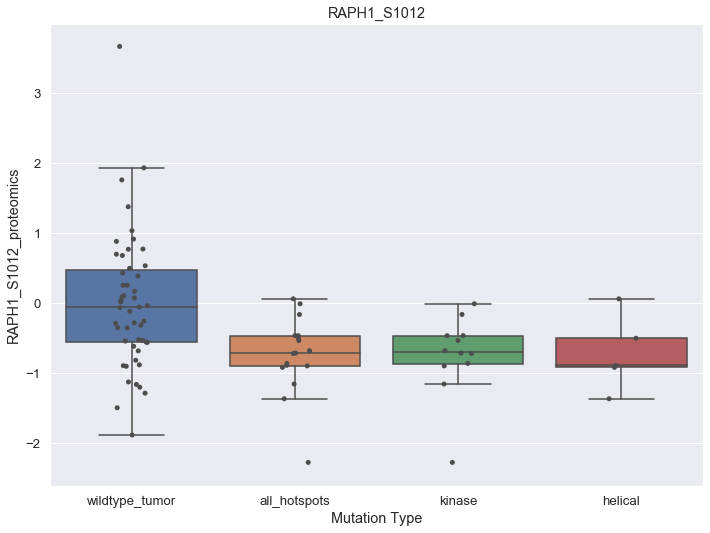

In [16]:
df = gene_df
gene =gene_site

plt.rcParams['figure.figsize']=(11.7,8.5) #size of plot
sns.set(font_scale = 1.2)

boxplot = sns.boxplot(x='type', y=gene, data = df, showfliers = False)  

boxplot.set_title(gene)

boxplot = sns.stripplot(x='type', y=gene, data = df, jitter = True, 
                           color = ".3", dodge = True)

boxplot.set(xlabel = "Mutation Type", ylabel = gene+"_proteomics")


plt.show()
plt.clf()
plt.close()

In [17]:
cl = cptac.Colon()

In [18]:
cl.get_phosphoproteomics()

Name           AAAS                 AAED1  AAGAB          AAK1                \
Site           S495   S525    S541    S12   S310   S311    S20    S21    S26   
Database_ID  Q9NRG9 Q9NRG9  Q9NRG9 Q7RTV5 Q6PD74 Q6PD74 Q2M2I8 Q2M2I8 Q2M2I8   
Patient_ID                                                                     
01CO005         NaN    NaN -0.2400 -0.460    NaN    NaN -0.231    NaN    NaN   
01CO006     -0.3650    NaN     NaN -0.424 -0.015 -0.015    NaN -0.485    NaN   
01CO008      0.7250  0.137  0.1370    NaN    NaN    NaN    NaN    NaN    NaN   
01CO013      0.2265    NaN     NaN -1.278  0.403  0.075 -0.223 -0.701    NaN   
01CO014      0.5600    NaN     NaN -0.382    NaN    NaN    NaN -0.259    NaN   
...             ...    ...     ...    ...    ...    ...    ...    ...    ...   
21CO006.N   -0.3240 -0.482 -0.1945  0.158    NaN    NaN  0.102 -0.461    NaN   
21CO007.N   -1.0220    NaN     NaN    NaN    NaN    NaN  0.670  0.342    NaN   
22CO004.N   -0.6120    NaN     NaN -0.404    NaN -0.493    NaN -0.072    NaN   
22CO006.N   -0.3970    NaN     NaN    NaN    NaN    NaN    NaN    NaN    NaN   
27CO004.N       NaN    NaN  0.5060 -0.028    NaN    NaN    NaN -0.403    NaN   

Name                ...  ZZEF1                                ZZZ3         \
Site          S618  ...  S1501   S1518  S1537  S1540  T1521   S113   S391   
Database_ID Q2M2I8  ... O43149  O43149 O43149 O43149 O43149 Q8IYH5 Q8IYH5   
Patient_ID          ...                                                     
01CO005        NaN  ...    NaN -0.6750 -1.404 -1.404    NaN -0.572    NaN   
01CO006        NaN  ...    NaN -0.2875  0.222  0.222 -0.701  0.624    NaN   
01CO008        NaN  ... -0.147 -0.1470    NaN    NaN    NaN    NaN    NaN   
01CO013        NaN  ... -0.041  0.0430  0.554  0.554  0.127  1.263    NaN   
01CO014        NaN  ...    NaN -0.1290 -0.919 -0.919    NaN  0.032    NaN   
...            ...  ...    ...     ...    ...    ...    ...    ...    ...   
21CO006.N      NaN  ...    NaN  0.3630  1.549  1.549    NaN    NaN    NaN   
21CO007.N      NaN  ...    NaN  0.5570 -0.004 -0.004  0.546    NaN    NaN   
22CO004.N      NaN  ...    NaN     NaN    NaN    NaN    NaN    NaN -0.179   
22CO006.N      NaN  ...    NaN     NaN  0.557  0.557    NaN    NaN    NaN   
27CO004.N      NaN  ...    NaN     NaN -0.286 -0.286    NaN    NaN  0.066   

Name                              
Site          S606    S90    S91  
Database_ID Q8IYH5 Q8IYH5 Q8IYH5  
Patient_ID                        
01CO005      0.205    NaN    NaN  
01CO006        NaN    NaN    NaN  
01CO008        NaN    NaN  -0.03  
01CO013        NaN    NaN    NaN  
01CO014      0.026    NaN    NaN  
...            ...    ...    ...  
21CO006.N      NaN  0.379    NaN  
21CO007.N   -0.090  0.043    NaN  
22CO004.N      NaN    NaN    NaN  
22CO006.N      NaN    NaN    NaN  
27CO004.N   -0.560    NaN    NaN  

[197 rows x 31339 columns]

In [19]:
def get_df(gene_list, site=None):
    #select the ones that are from the paper
    phos = cl.get_phosphoproteomics(tissue_type="tumor")
    genefilter = phos.columns.get_level_values("Name").isin(gene_list)
    phos_62 = phos[phos.columns[genefilter]]
    phos_62 = cptac.utils.reduce_multiindex(phos_62, flatten=True)
    phos_62

    #join mutation
    #get mutation_tyoe
    mut_type = cl.get_genotype_all_vars('PIK3CA')

    #join proteomics and mutation type
    joined = mut_type.join(phos_62)

    #select samples containing hotspot mutations
    br_hotspot_df = joined[joined.Location.str.contains('E542K') | 
                        joined.Location.str.contains('E545K') |
                        joined.Location.str.contains('H1047R')]


    #join wildtype proteomics to missense mutation proteomics 
    wildtype  = joined.loc[joined.Mutation == "Wildtype_Tumor"]
    brca_hotspot = br_hotspot_df.append(wildtype)

    #drop unncessary columns
    phos_62 = brca_hotspot.drop(columns = ["Mutation_Status", "Location"])
    
    df = phos_62
    site_name = ["Mutation"]
    for name in df:
        if name != "Mutation":
            both = "_".join([name.split('_', 3)[0],name.split('_', 3)[1]])
            site_name.append(both)
#             site_name.append(name.split('_', 3)[1]
            
    df.columns = site_name
    
    if site != None:
        df = df[["Mutation", site]]
    
    return(df)

In [20]:
gene = "NFIA"
# site = gene+"_"+ "S1012"
site = None
df = get_df([gene], site)
df = df.loc[:,~df.columns.duplicated(keep="first")]
df

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 82 samples for the PIK3CA gene (/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/cptac/dataset.py, line 311)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: 05CO045 (/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/cptac/dataset.py, line 311)


,Mutation,NFIA_S193,NFIA_S258,NFIA_S265,NFIA_S268,NFIA_S273,NFIA_S274,NFIA_S280,NFIA_S287,NFIA_S300,NFIA_S305,NFIA_S308,NFIA_S319,NFIA_T272
Patient_ID,,,,,,,,,,,,,,
05CO028,nonsynonymous SNV,NaN,NaN,-0.481,NaN,NaN,NaN,-0.8810,-0.4740,NaN,NaN,NaN,NaN,NaN
05CO032,nonsynonymous SNV,NaN,-0.3915,NaN,NaN,NaN,NaN,-0.4095,-0.1305,NaN,NaN,NaN,NaN,NaN
09CO005,nonsynonymous SNV,NaN,-0.8300,-0.270,-0.984,NaN,NaN,-1.0545,-0.3945,0.5450,NaN,NaN,NaN,NaN
11CO027,nonsynonymous SNV,NaN,-0.8960,NaN,NaN,NaN,NaN,-0.8570,-1.3450,0.1145,NaN,NaN,-0.482,NaN
11CO052,nonsynonymous SNV,NaN,-0.6110,NaN,NaN,NaN,NaN,-1.1970,-0.8020,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20CO001,Wildtype_Tumor,NaN,NaN,0.345,NaN,NaN,NaN,0.3390,0.4460,0.6150,NaN,NaN,NaN,NaN
20CO003,Wildtype_Tumor,NaN,0.3280,-0.610,NaN,NaN,-0.126,-0.1530,0.1280,0.0690,NaN,NaN,NaN,NaN
22CO004,Wildtype_Tumor,-0.345,-0.4260,-0.364,NaN,NaN,NaN,0.0300,-0.0680,-0.2360,NaN,NaN,-0.363,-0.081


In [21]:
wrap_ttest(df, "Mutation", correction_method="fdr_bh", return_all=True, pval_return_corrected=False)

,Comparison,P_Value
0,NFIA_S300,0.139818
1,NFIA_S280,0.214465
2,NFIA_S258,0.223106
3,NFIA_S287,0.583051
4,NFIA_S265,0.877284


# ENDO

In [22]:
en = cptac.Endometrial()

In [23]:
def get_df(gene_list, site=None):
    #select the ones that are from the paper
    phos = en.get_phosphoproteomics(tissue_type="tumor")
    genefilter = phos.columns.get_level_values("Name").isin(gene_list)
    phos_62 = phos[phos.columns[genefilter]]
    phos_62 = cptac.utils.reduce_multiindex(phos_62, flatten=True)
    phos_62

    #join mutation
    #get mutation_tyoe
    mut_type = en.get_genotype_all_vars('PIK3CA')

    #join proteomics and mutation type
    joined = mut_type.join(phos_62)

    #select samples containing hotspot mutations
    br_hotspot_df = joined[joined.Location.str.contains('E542K') | 
                        joined.Location.str.contains('E545K') |
                        joined.Location.str.contains('H1047R')]


    #join wildtype proteomics to missense mutation proteomics 
    wildtype  = joined.loc[joined.Mutation == "Wildtype_Tumor"]
    brca_hotspot = br_hotspot_df.append(wildtype)

    #drop unncessary columns
    phos_62 = brca_hotspot.drop(columns = ["Mutation_Status", "Location"])
    
    df = phos_62
    site_name = ["Mutation"]
    for name in df:
        if name != "Mutation":
            both = "_".join([name.split('_', 3)[0],name.split('_', 3)[1]])
            site_name.append(both)
#             site_name.append(name.split('_', 3)[1]
            
    df.columns = site_name
    
    if site != None:
        df = df[["Mutation", site]]
    
    return(df)

In [24]:
gene = "NFIA"
# site = gene+"_"+ "S1012"
site = None
df = get_df([gene], site)
df = df.loc[:,~df.columns.duplicated(keep="first")]
df

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 48 samples for the PIK3CA gene (/Users/hannahboekweg/anaconda3/lib/python3.7/site-packages/cptac/dataset.py, line 311)


,Mutation,NFIA_S233,NFIA_S238,NFIA_S240,NFIA_S292,NFIA_S301,NFIA_S303,NFIA_S310,NFIA_S313,NFIA_S315,...,NFIA_S507,NFIA_S517,NFIA_T279,NFIA_T314,NFIA_T317,NFIA_T320,NFIA_T366,NFIA_T389,NFIA_T392,NFIA_T400
Patient_ID,,,,,,,,,,,,,,,,,,,,,
C3L-00006,Missense_Mutation,NaN,NaN,NaN,NaN,NaN,NaN,-0.27700,-0.448000,-0.23340,...,NaN,NaN,NaN,-0.2610,-0.20200,-0.0277,NaN,NaN,NaN,NaN
C3L-00032,Missense_Mutation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.30900,...,NaN,NaN,NaN,-0.2170,-1.17000,NaN,NaN,NaN,NaN,NaN
C3L-00362,Missense_Mutation,NaN,NaN,NaN,NaN,NaN,NaN,-0.24250,0.512000,-0.05815,...,NaN,NaN,NaN,0.2400,-0.23400,0.0000,NaN,NaN,NaN,NaN
C3L-00601,Missense_Mutation,NaN,NaN,NaN,NaN,NaN,NaN,-0.07550,0.561500,NaN,...,NaN,NaN,NaN,0.4360,0.76800,NaN,NaN,NaN,NaN,NaN
C3L-00605,Missense_Mutation,-0.9140,NaN,-0.2210,NaN,NaN,-2.89000,-1.12000,NaN,-0.75400,...,NaN,NaN,NaN,-0.4350,-1.12000,NaN,NaN,NaN,NaN,NaN
C3L-00921,Missense_Mutation,NaN,NaN,NaN,NaN,-0.0159,0.11305,0.17900,0.368500,0.64400,...,NaN,NaN,NaN,1.0800,NaN,NaN,NaN,NaN,NaN,NaN
C3L-00947,Missense_Mutation,NaN,NaN,NaN,NaN,NaN,NaN,-0.34400,NaN,-0.13100,...,NaN,NaN,NaN,-0.0514,NaN,NaN,NaN,NaN,NaN,NaN
C3N-00323,Missense_Mutation,NaN,NaN,NaN,NaN,NaN,NaN,0.24585,0.942000,0.39125,...,NaN,NaN,NaN,NaN,0.94700,NaN,NaN,-0.0688,NaN,-0.0688
C3N-00324,Missense_Mutation,-0.6100,NaN,-1.0600,NaN,NaN,NaN,0.08740,0.016200,0.47500,...,NaN,NaN,NaN,-0.2340,-0.13500,NaN,NaN,NaN,NaN,NaN


In [25]:
wrap_ttest(df, "Mutation", correction_method="fdr_bh", return_all=True, pval_return_corrected=False)

,Comparison,P_Value
0,NFIA_S313,0.058200
1,NFIA_S468,0.217686
2,NFIA_S318,0.255809
3,NFIA_T314,0.502303
4,NFIA_T317,0.512266
5,NFIA_S345,0.526156
6,NFIA_S316,0.583550
7,NFIA_S325,0.737122
8,NFIA_S364,0.805814
9,NFIA_S310,0.813386
